# Code for controlling laser and oscilloscope

## Initialization

In [1]:
import pyvisa as visa
import time

In [2]:
resouce_manager = visa.ResourceManager()

In [3]:
#resouce_manager.list_resources()

('TCPIP::18.25.24.2::INSTR',
 'TCPIP::18.25.25.150::INSTR',
 'TCPIP::18.25.26.1::INSTR',
 'TCPIP::18.25.28.8::INSTR',
 'TCPIP::18.25.28.190::INSTR',
 'TCPIP::18.25.29.146::INSTR',
 'TCPIP::18.25.31.122::INSTR')

In [3]:
osc = resouce_manager.open_resource('TCPIP::18.25.28.8::INSTR')
print(osc.query('*IDN?'))

RIGOL TECHNOLOGIES,DS7034,DS7A241700250,00.01.02.01.03



In [8]:
ins = resouce_manager.open_resource('TCPIP::18.25.25.33::5025::SOCKET',timeout=25000)
ins.read_termination='\r'
ins.write_termination='\r'
ins.query('*IDN?')

'SANTEC,TSL-570,22010054,0016.0014.0008'

## Control

In [9]:
#set laser output range and step
starting_pow_val = 12
ending_pow_val = -16
step_pow = -3
waiting_time_after_reset = 3 # after the osc reset its statitcs, we need to wait this time to get the average of average.
laser_stablize_time = 2 # waiting time after setting laser power level

input_laser_pow = list(range(starting_pow_val, ending_pow_val, step_pow))
ins.write(':POW:SHUT 0')
ins.write(':POW UNIT 0')
ins.write(':POW {}dBm'.format(starting_pow_val))

11

## loop and make the plot

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import pandas as pd

def lin_fit_func(x, slope, intercept):
    return slope * x + intercept

In [12]:
grp_a_working_channel_dic = {
    '63':'g8',
#     '59':'g7',
#     '55':'g4',
#     '47':'h8',
#     '45':'h6',
#     '43':'h7',
#     '35':'h3',
#     '31':'a8',
#     '27':'a7',
#     '23':'a4',
#     '21':'a2',
#     '19':'a3',
#     '15':'b8',
#     '11':'b7',
#     '3':'b3'
}

grp_a_working_channel = list(grp_a_working_channel_dic.keys())

Channel 63: Are you aligned or not? yes
channel 63 laser power [12.005]
channel 63 laser power [12.005, 9.006]
channel 63 laser power [12.005, 9.006, 6.006]
channel 63 laser power [12.005, 9.006, 6.006, 3.007]
channel 63 laser power [12.005, 9.006, 6.006, 3.007, 0.005]
channel 63 laser power [12.005, 9.006, 6.006, 3.007, 0.005, -2.996]
channel 63 laser power [12.005, 9.006, 6.006, 3.007, 0.005, -2.996, -5.994]
channel 63 laser power [12.005, 9.006, 6.006, 3.007, 0.005, -2.996, -5.994, -8.993]
channel 63 laser power [12.005, 9.006, 6.006, 3.007, 0.005, -2.996, -5.994, -8.993, -11.994]
channel 63 laser power [12.005, 9.006, 6.006, 3.007, 0.005, -2.996, -5.994, -8.993, -11.994, -14.994]
[ 1.2005e+01  9.0060e+00  6.0060e+00  3.0070e+00  5.0000e-03 -2.9960e+00
 -5.9940e+00 -8.9930e+00 -1.1994e+01 -1.4994e+01]


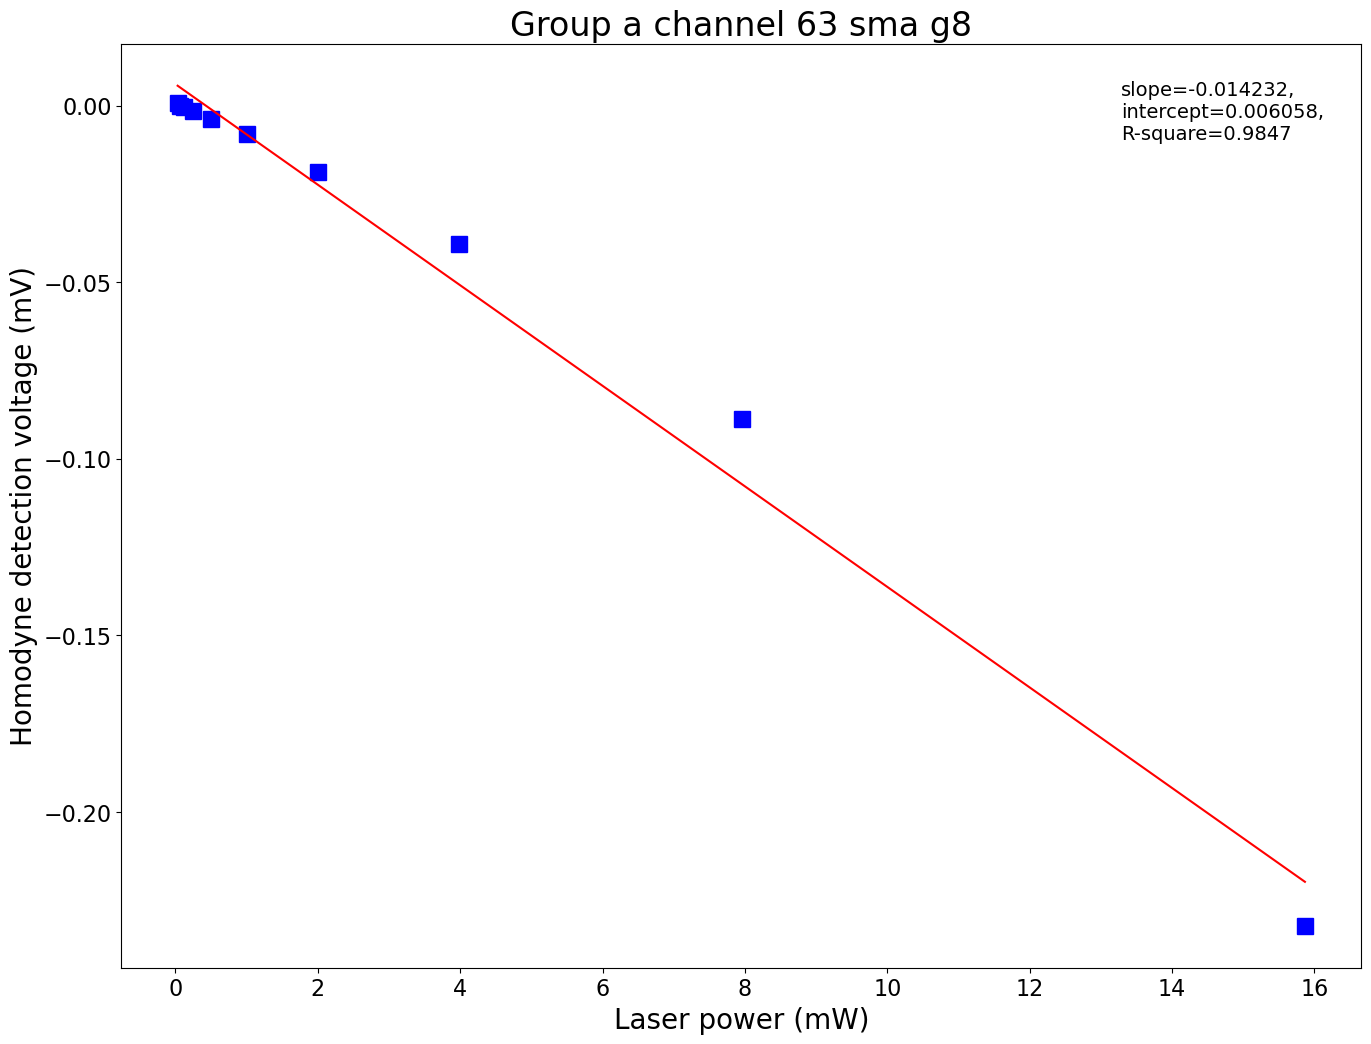

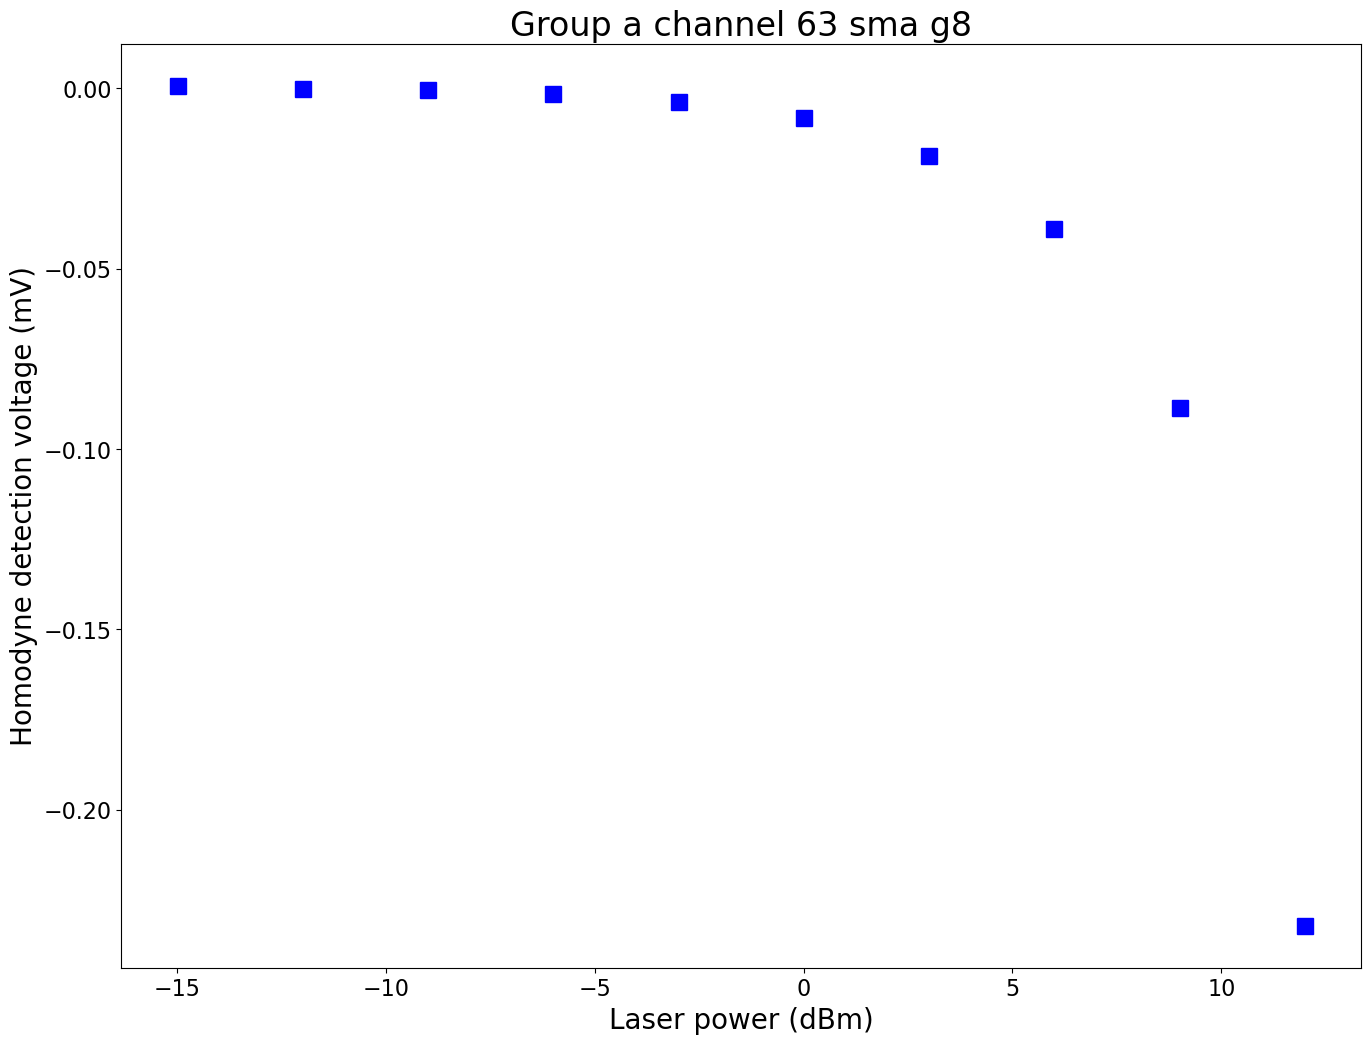

In [13]:
results = []

for c in grp_a_working_channel:
    while True:
        ins.write(':POW {}dBm'.format(starting_pow_val))
        status = input("Channel {}: Are you aligned or not? ".format(c))
#         ins.write(':POW {}dBm'.format(starting_pow_val))
        if (status.lower() == 'yes'):
            # manually clean the vector for storage every channel
            actu_laser_pow_dbm = []
            actu_laser_pow_mw = []
            osc_volt = []
            for i in input_laser_pow:
                laser_str = ":POW {}dBm".format(i)
                ins.write(laser_str)
                time.sleep(laser_stablize_time)
                current_act_laser_pow_dbm = float(ins.query(':POW:ACT?'))
                #current_act_laser_pow_mw = np.power(10.0,(current_act_laser_pow_dbm/10.0))
                actu_laser_pow_dbm.append(current_act_laser_pow_dbm)
                print('channel {} laser power {}'.format(c,actu_laser_pow_dbm))
                osc.write(':MEAS:STAT:RES')
                time.sleep(waiting_time_after_reset)
                osc_volt.append(float(osc.query(':MEAS:STAT:ITEM? AVER,VAVG')))
                #osc_volt.append(current_act_laser_pow_mw)
            # change to unit mw
            actu_laser_pow_dbm = np.array(actu_laser_pow_dbm)
            actu_laser_pow_mw = np.power(10.0,np.divide(actu_laser_pow_dbm,10.0))
            osc_volt = np.array(osc_volt)
            # fitting codes start here
            params, covariance = curve_fit(lin_fit_func, actu_laser_pow_mw, osc_volt)
            slope, intercept = params
            # plotting codes start here
            fig = plt.figure(figsize=(16,12))
            #
            print(actu_laser_pow_dbm)
            #
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)
            plt.plot(actu_laser_pow_mw,osc_volt,color='b',marker="s",markersize=12,linewidth=0)
                # plot the fitted line
            plt.plot(actu_laser_pow_mw, lin_fit_func(actu_laser_pow_mw,slope,intercept), color='r')
            y_pred = lin_fit_func(actu_laser_pow_mw, slope, intercept)
            r_squared = r2_score(osc_volt, y_pred)
            plt.text(0.75,0.8,'slope={:.6f},\nintercept={:.6f},\nR-square={:.4f}'.format(slope,intercept,r_squared),fontsize = 14, transform=plt.gcf().transFigure)
            plt.xlabel('Laser power (mW)',fontsize=20)
            plt.ylabel('Homodyne detection voltage (mV)',fontsize=20)
            plt.title("Group a channel {} sma {}".format(c,grp_a_working_channel_dic.get(c,"WRONG_CHANNEL")),fontsize=24)
            plt.show()
            # exporting fig
            fig.savefig("grp_a_channel{}_sma_{}_mw.pdf".format(c,grp_a_working_channel_dic.get(c,"WRONG_CHANNEL")),dpi=300,format="pdf")
            # plotting codes finish here
            # export csv file, store results
                 # Calculate R-squared
#             y_pred = lin_fit_func(actu_laser_pow_mw, slope, intercept)
#             r_squared = r2_score(osc_volt, y_pred)
            result = {
                "channel_number": c,
                "location": grp_a_working_channel_dic.get(c,"WRONG_CHANNEL"),
                "slope": slope,
                "intercept": intercept,
                "r_squared": r_squared
            }
            results.append(result)
            # dBm plotting codes start here
            fig_dbm = plt.figure(figsize=(16,12))
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)
            plt.plot(actu_laser_pow_dbm,osc_volt,color='b',marker="s",markersize=12,linewidth=0)
            plt.xlabel('Laser power (dBm)',fontsize=20)
            plt.ylabel('Homodyne detection voltage (mV)',fontsize=20)
            plt.title("Group a channel {} sma {}".format(c,grp_a_working_channel_dic.get(c,"WRONG_CHANNEL")),fontsize=24)
            plt.show()
            # exporting fig
            fig_dbm.savefig("grp_a_channel{}_sma_{}_dbm.pdf".format(c,grp_a_working_channel_dic.get(c,"WRONG_CHANNEL")),dpi=300,format="pdf")
            break
        elif status.lower() == 'no':
            break
        else:
            print("Invalid input, please enter yes or no.")
# Convert results to DataFrame
df = pd.DataFrame(results)
# Export DataFrame to CSV
df.to_csv("channel_fitting_results.csv", index=False)

In [14]:
ins.close()